In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),
    ]
)

In [7]:
full_train_dataset = datasets.ImageFolder("chest_Xray/train", transform=transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)
model.features[0][0].in_channels = 1
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model = model.to(device)

c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maiab\.conda\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\maiab/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 20.9MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/5, Loss: 0.1957
Epoch 2/5, Loss: 0.0482
Epoch 3/5, Loss: 0.0315
Epoch 4/5, Loss: 0.0189
Epoch 5/5, Loss: 0.0189


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       263
           1       0.99      0.99      0.99       781

    accuracy                           0.99      1044
   macro avg       0.98      0.99      0.98      1044
weighted avg       0.99      0.99      0.99      1044



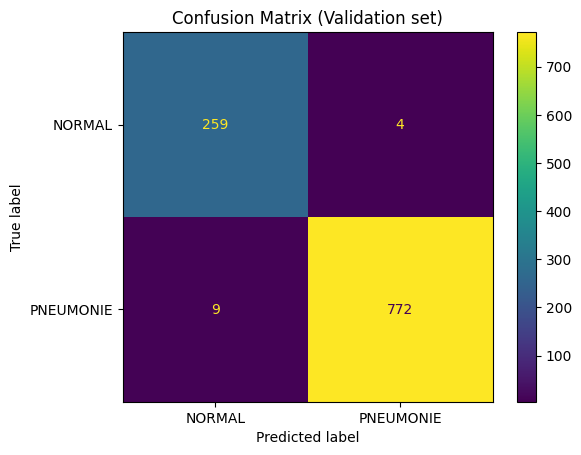

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("Classification Report:\n", classification_report(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=["NORMAL", "PNEUMONIE"]
)
plt.title("Confusion Matrix (Validation set)")
plt.show()

Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74       234
           1       0.80      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



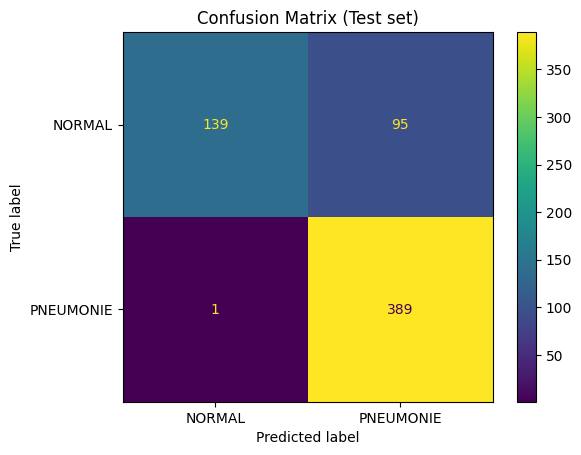

In [ ]:
test_dataset = datasets.ImageFolder("chest_Xray/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true_test, y_pred_test = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred_test.extend(preds)
        y_true_test.extend(labels.numpy())

print("Test Classification Report:\n", classification_report(y_true_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(
    y_true_test, y_pred_test, display_labels=["NORMAL", "PNEUMONIE"]
)
plt.title("Confusion Matrix (Test set)")
plt.show()

In [ ]:
import pandas as pd

# Create dataframes for the validation results
val_cm = confusion_matrix(y_true, y_pred)
val_cm_df = pd.DataFrame(
    val_cm, index=["NORMAL", "PNEUMONIE"], columns=["NORMAL", "PNEUMONIE"]
)
val_cm_df.index.name = "Actual"
val_cm_df.columns.name = "Predicted"

# Get classification report as dictionary and convert to DataFrame
val_cr_dict = classification_report(y_true, y_pred, output_dict=True)
val_cr_df = pd.DataFrame(val_cr_dict).transpose()

# Create dataframes for the test results
test_cm = confusion_matrix(y_true_test, y_pred_test)
test_cm_df = pd.DataFrame(
    test_cm, index=["NORMAL", "PNEUMONIE"], columns=["NORMAL", "PNEUMONIE"]
)
test_cm_df.index.name = "Actual"
test_cm_df.columns.name = "Predicted"

# Get classification report as dictionary and convert to DataFrame
test_cr_dict = classification_report(y_true_test, y_pred_test, output_dict=True)
test_cr_df = pd.DataFrame(test_cr_dict).transpose()

# Save to parquet files
# model_name = "efficientnet_b0"
val_cm_df.to_parquet(f"results_efficentnet/val_confusion_matrix.parquet")
val_cr_df.to_parquet(f"results_efficentnet/val_classification_report.parquet")
test_cm_df.to_parquet(f"results_efficentnet/test_confusion_matrix.parquet")
test_cr_df.to_parquet(f"results_efficentnet/test_classification_report.parquet")

print("Confusion matrices and classification reports saved as parquet files")

Confusion matrices and classification reports saved as parquet files
